In [1]:
#!pip install altair

In [2]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from collections import Counter
import networkx as nx
from tqdm import tqdm

In [3]:
from google.cloud import bigquery
client = bigquery.Client()

In [4]:
# 2022/06/16-2022/12/17 transaction count, gas price average, value average
trans_data_6mon_query = """
    SELECT COUNT(*) as trans_num, FLOOR(AVG(gas_price)) as gas_price_avg, FLOOR(AVG(value)) as value_avg, DATE(block_timestamp) as date_col
    FROM `big-data-363423.eth_dataset.transactions` 
    WHERE DATE(block_timestamp) >= "2022-06-16" AND DATE(block_timestamp) < "2022-12-17"
    GROUP BY date_col
    ORDER BY date_col ASC;
"""
trans_data_6mon = client.query(trans_data_6mon_query)

In [5]:
# this is my project ID. When using the public(and table names), 
# when using Ethereum ETL on your own, please download and then change.
my_proj_id = 'big-data-363423'
trans_data_6mon_df = trans_data_6mon.to_dataframe()
trans_data_6mon_df.head()

,trans_num,gas_price_avg,value_avg,date_col
0,1100312,4.518098e+10,3530030934392770135.000000000,2022-06-16
1,1110579,4.559944e+10,3134415601639097329.000000000,2022-06-17
2,1058336,5.585561e+10,3708579810872018723.000000000,2022-06-18
3,1018674,3.265481e+10,2464595120600576282.000000000,2022-06-19
4,1042748,3.137555e+10,2634140201682392033.000000000,2022-06-20


In [6]:
df = trans_data_6mon_df
df.shape

(184, 4)

In [7]:
df['value_avg'] = df['value_avg'].astype(str).astype(float).astype(int)
df['gas_price_avg'] = df['gas_price_avg'].astype(int)

In [8]:
trans_data_6mon_df.dtypes

trans_num         int64
gas_price_avg     int64
value_avg         int64
date_col         object
dtype: object

In [9]:
df.head()

,trans_num,gas_price_avg,value_avg,date_col
0,1100312,45180977935,3530030934392770048,2022-06-16
1,1110579,45599442508,3134415601639097344,2022-06-17
2,1058336,55855612594,3708579810872018944,2022-06-18
3,1018674,32654814092,2464595120600576512,2022-06-19
4,1042748,31375548160,2634140201682392064,2022-06-20


Text(0, 0.5, 'Transaction count')

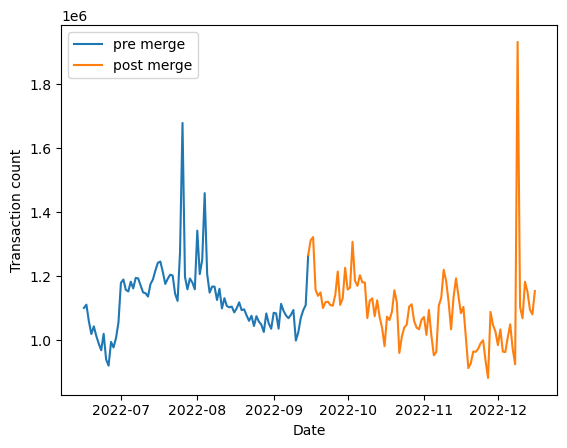

In [10]:
df_pre = df[df['date_col'] <= datetime.date(2022, 9, 15)]
df_post = df[df['date_col'] >= datetime.date(2022, 9, 15)]

#plt.plot(df['date_col'], df['trans_num'])
plt.plot(df_pre['date_col'], df_pre['trans_num'])
plt.plot(df_post['date_col'], df_post['trans_num'])
plt.legend(['pre merge', 'post merge'])
plt.xlabel("Date")
plt.ylabel("Transaction count")
#plt.title("Ethereum Transactions")

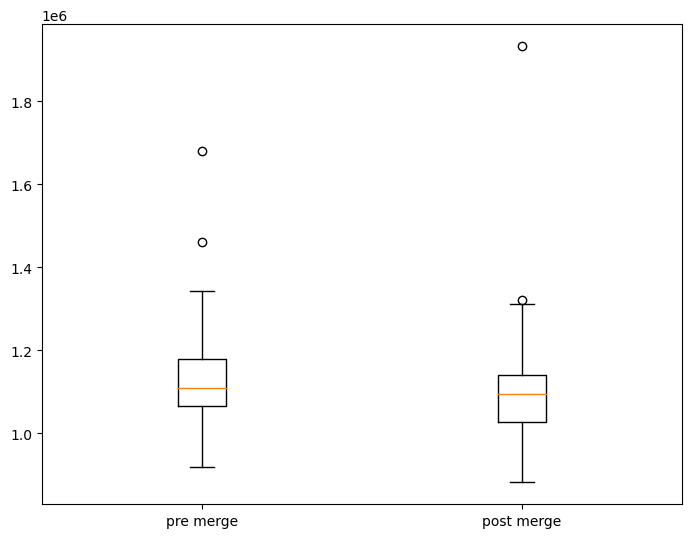

In [11]:
data = [df_pre['trans_num'], df_post['trans_num']
        #, df_pre['gas_price_avg'], df_post['gas_price_avg'], df_pre['value_avg'], df_post['value_avg']
       ]
#fig = plt.figure(figsize =(10, 7)) 
fig = plt.figure()
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
plt.xticks([1, 2], ['pre merge', 'post merge'])
plt.show()

In [12]:
#df.time_diff.quantile([0.25,0.5,0.75])
print("pre merge transaction count quantiles: \n" + str(df_pre.trans_num.quantile([0.25,0.5,0.75])))

print("post merge transaction count quantiles: \n" + str(df_post.trans_num.quantile([0.25,0.5,0.75])))

pre merge transaction count quantiles: 
0.25    1066207.00
0.50    1109875.50
0.75    1178902.25
Name: trans_num, dtype: float64
post merge transaction count quantiles: 
0.25    1026508.0
0.50    1093977.0
0.75    1141218.0
Name: trans_num, dtype: float64


Text(0, 0.5, 'Average gas price(Wei)')

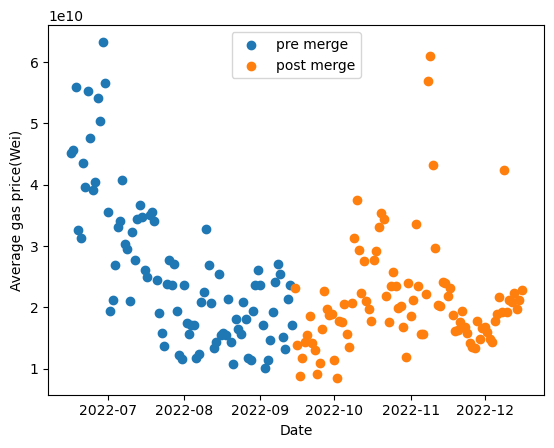

In [24]:
df_pre = df[df['date_col'] < datetime.date(2022, 9, 15)]
df_post = df[df['date_col'] >= datetime.date(2022, 9, 15)]

#plt.scatter(df['date_col'], df['gas_price_avg'])
plt.scatter(df_pre['date_col'], df_pre['gas_price_avg'])
plt.scatter(df_post['date_col'], df_post['gas_price_avg'])
plt.legend(['pre merge', 'post merge'])
plt.xlabel("Date")
plt.ylabel("Average gas price(Wei)")
#plt.title("Ethereum Transactions")

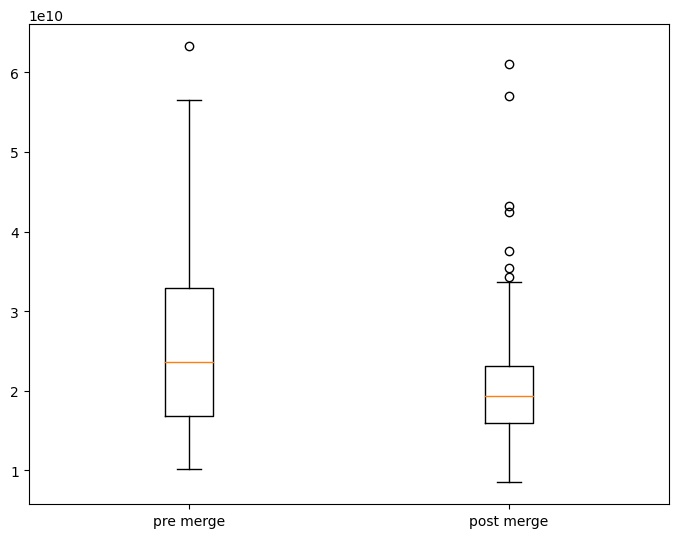

In [25]:
data = [df_pre['gas_price_avg'], df_post['gas_price_avg']]
#fig = plt.figure(figsize =(10, 7)) 
fig = plt.figure()
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
plt.xticks([1, 2], ['pre merge', 'post merge'])
plt.show()

In [26]:
#df.time_diff.quantile([0.25,0.5,0.75])
print("pre merge transaction count quantiles: \n" + str(df_pre.gas_price_avg.quantile([0.25,0.5,0.75])))

print("post merge transaction count quantiles: \n" + str(df_post.gas_price_avg.quantile([0.25,0.5,0.75])))

pre merge transaction count quantiles: 
0.25    1.679810e+10
0.50    2.360541e+10
0.75    3.295918e+10
Name: gas_price_avg, dtype: float64
post merge transaction count quantiles: 
0.25    1.594320e+10
0.50    1.935230e+10
0.75    2.310248e+10
Name: gas_price_avg, dtype: float64


Text(0, 0.5, 'Average transaction value(Wei)')

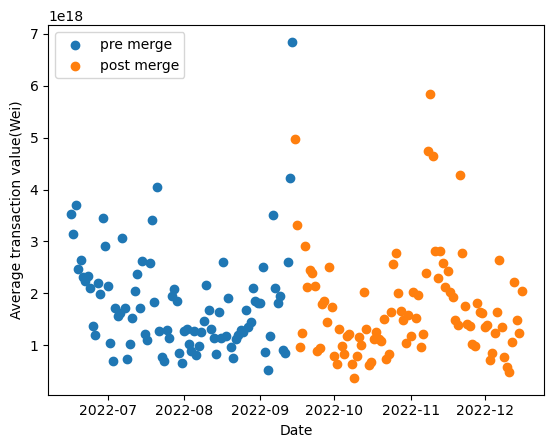

In [21]:
df_pre = df[df['date_col'] < datetime.date(2022, 9, 15)]
df_post = df[df['date_col'] >= datetime.date(2022, 9, 15)]

#plt.scatter(df['date_col'], df['gas_price_avg'])
plt.scatter(df_pre['date_col'], df_pre['value_avg'])
plt.scatter(df_post['date_col'], df_post['value_avg'])
plt.legend(['pre merge', 'post merge'], loc='upper left')
plt.xlabel("Date")
plt.ylabel("Average transaction value(Wei)")
#plt.title("Ethereum Transactions")

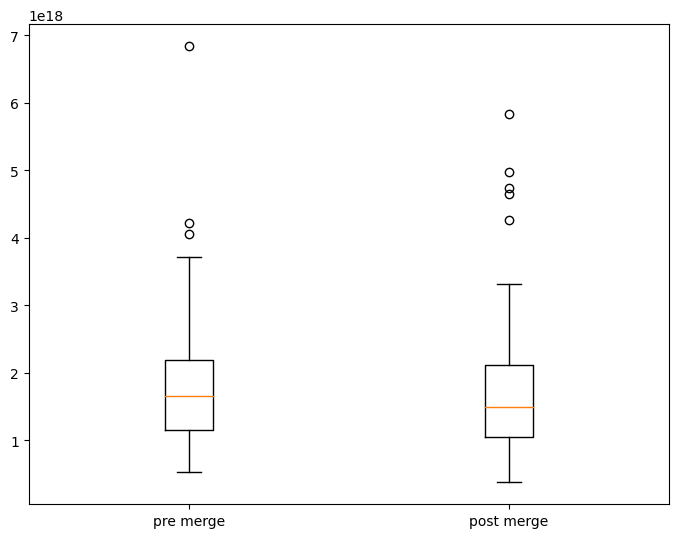

In [22]:
data = [df_pre['value_avg'], df_post['value_avg']]
#fig = plt.figure(figsize =(10, 7)) 
fig = plt.figure()
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
plt.xticks([1, 2], ['pre merge', 'post merge'])
plt.show()

In [23]:
#df.time_diff.quantile([0.25,0.5,0.75])
print("pre merge transaction count quantiles: \n" + str(df_pre.value_avg.quantile([0.25,0.5,0.75])))

print("post merge transaction count quantiles: \n" + str(df_post.value_avg.quantile([0.25,0.5,0.75])))

pre merge transaction count quantiles: 
0.25    1.148798e+18
0.50    1.648501e+18
0.75    2.185595e+18
Name: value_avg, dtype: float64
post merge transaction count quantiles: 
0.25    1.050241e+18
0.50    1.484778e+18
0.75    2.121209e+18
Name: value_avg, dtype: float64


In [27]:
post_merge_query = """
    SELECT * FROM `big-data-363423.eth_dataset.transactions`
    WHERE DATE(block_timestamp) >= "2022-10-16" AND DATE(block_timestamp) < "2022-10-17"
    AND (to_address) IS NOT NULL
    AND (gas_price) IS NOT NULL
"""
my_proj_id = 'big-data-363423'
post_merge = client.query(post_merge_query).to_dataframe()
#post_merge = pd.read_gbq(post_merge_query)
post_merge.head()

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,...,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
0,0x50b09032201a010b9f1828c575a3f0a382eb503d7af2...,1053,112,0x39cd9de6fc3a8dac9a41de08cecde6303ac9b052,0x00000000006c3852cbef3e08e8df289169ede581,90000000000000000.000000000,189191,16010132172,0xfb0f3ee1000000000000000000000000000000000000...,12444722,...,None,None,1,2022-10-16 00:12:11+00:00,15757017,0x2a4d2d191e4ec45dc7226f7b4571319322120e76bdd3...,2.135837e+10,1.500000e+09,2,16010132172
1,0x694401265ef0741856371f17306b7b7106ef4eeeebdc...,0,100,0x9f30c46a93e3ef2cc2ac2503ea60c309fff5f050,0x06450dee7fd2fb8e39061434babcfc05599a6fb8,0E-9,210000,13000000000,0x9ff054df000000000000000000000000000000000000...,15723217,...,None,None,1,2022-10-16 02:59:11+00:00,15757847,0xbd904c25a3674ca27ca11758e387f277897ce249e561...,NaN,NaN,0,13000000000
2,0x144449a2d5dd64378d71029430ab180982f82d86d629...,4810650,30,0x2faf487a4414fe77e2327f0bf4ae2a264a776ad2,0x7968bc6a03017ea2de509aaa816f163db0f35148,0E-9,68840,16508111942,0x23b872dd00000000000000000000000015f31ec379cc...,3572613,...,None,None,1,2022-10-16 04:32:47+00:00,15758313,0x61bbadd50254529b850e06c4f3011ad0aa1b08a51424...,1.000000e+12,3.996254e+09,2,16508111942
3,0x7a96ed438217fcf1a885611c919e9a4cae1f6be39d8d...,0,9,0x4bac51cebacbbb72a61b32031edb539b38624fc8,0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7,75307860000000000.000000000,21000,16460000000,0x,1302978,...,None,None,1,2022-10-16 22:39:35+00:00,15763712,0xa0c42c4ef9330a31a4c272bbd0b751d64f4bb931b5fd...,NaN,NaN,0,16460000000
4,0xacb6d142f598993bfcaf4e1fbd556a482eda8baf96fa...,1241,82,0x2d7fcf9cd77fe4c09577166b67c77d49d933c265,0xddf6dd8a8d74345c9efa6820a1b67aa7d3fb7016,20000000000000000.000000000,21000,13287651372,0x,19707939,...,None,None,1,2022-10-16 04:23:35+00:00,15758267,0x16510450942ebdf2acb22f2581e7b4221f1074bf839c...,1.780076e+10,3.100000e+08,2,13287651372


In [28]:
post_merge.shape

(979576, 21)

In [29]:
post_merge.dtypes

hash                                        object
nonce                                        int64
transaction_index                            int64
from_address                                object
to_address                                  object
value                                       object
gas                                          int64
gas_price                                    int64
input                                       object
receipt_cumulative_gas_used                  int64
receipt_gas_used                             int64
receipt_contract_address                    object
receipt_root                                object
receipt_status                               int64
block_timestamp                datetime64[ns, UTC]
block_number                                 int64
block_hash                                  object
max_fee_per_gas                            float64
max_priority_fee_per_gas                   float64
transaction_type               

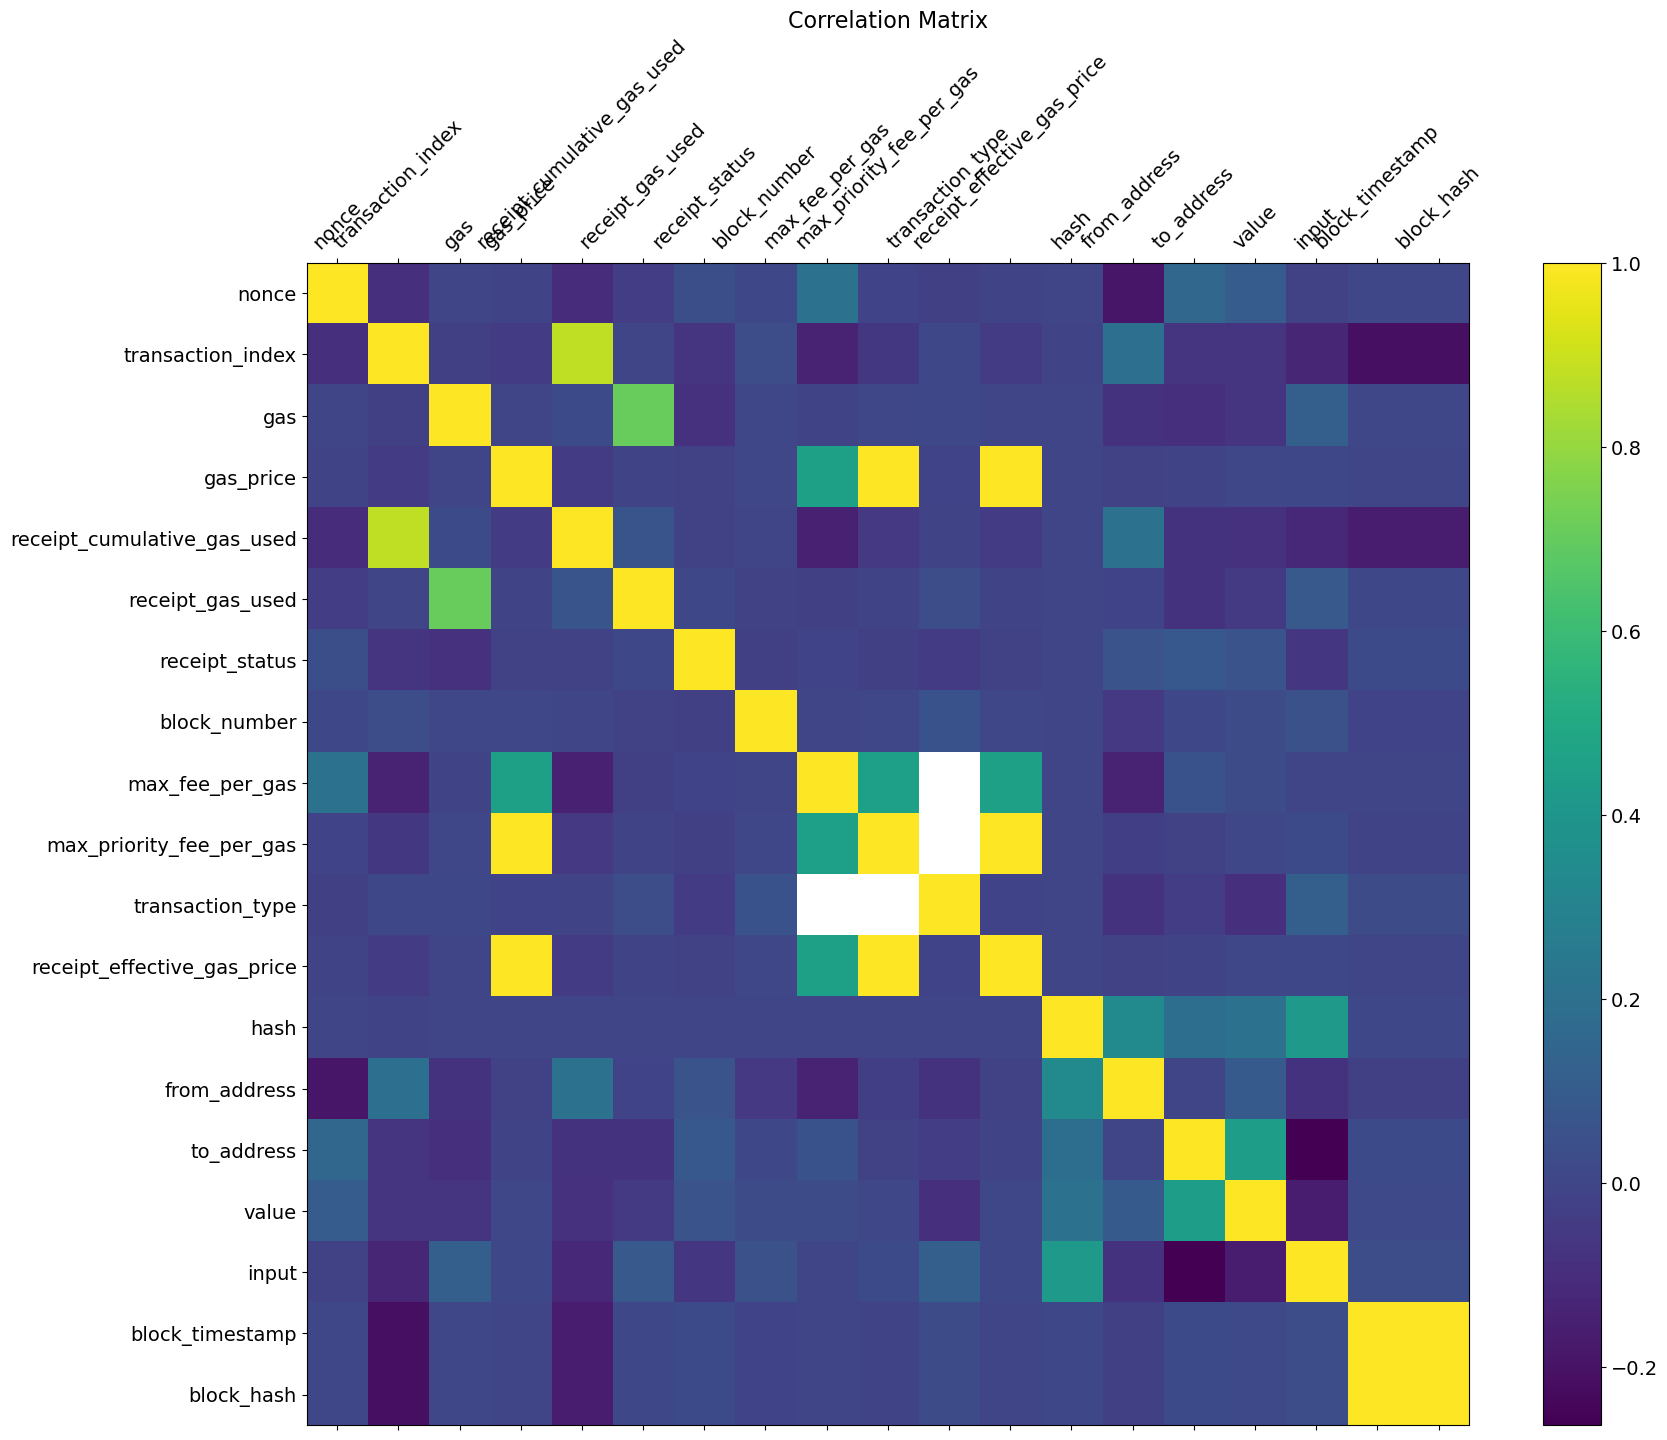

In [30]:
df = post_merge
df.drop(['receipt_contract_address', 'receipt_root'], axis=1, inplace=True)
df_cat = df.select_dtypes(exclude=['number']).apply(lambda x: pd.factorize(x)[0])
df = pd.concat([df.select_dtypes(['number']), df_cat], axis=1)
f = plt.figure(figsize=(19, 15))
feat_num = df.shape[1]

plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(feat_num), df.columns, fontsize=14, rotation=45)
plt.yticks(range(feat_num), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);